# ACP : Exemple simple

## Pré-étude des données

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10)

Ecart type : 3.4729999129083966
Moyenne : 10.222222222222221
Variance : 12.06172839506173


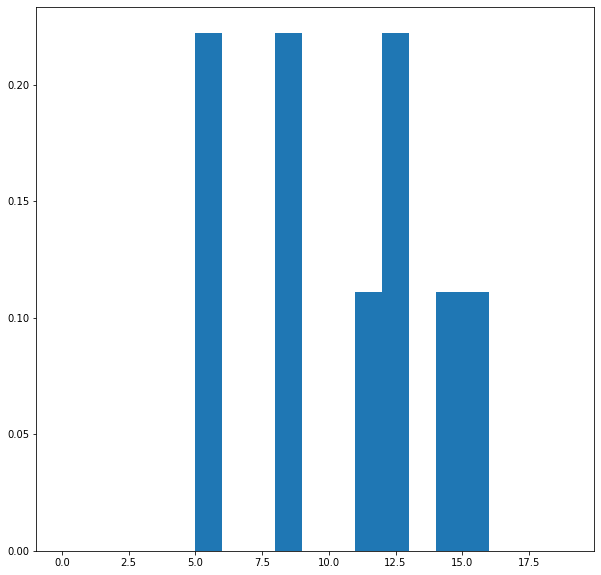

In [2]:
import pandas as pd

X = pd.read_csv("notes.csv",sep=";",decimal=".",header=0,index_col = 0)
X = np.transpose(X)

nomi = list(X.index)
nomv = list(X.columns)

FRAN_VALUES = X.loc[:,['fran']].values 


plt.hist(FRAN_VALUES, bins=range(20), density=True)
print('Ecart type : ' + str(np.std(FRAN_VALUES)))
print('Moyenne : ' + str(np.mean(FRAN_VALUES)))
print('Variance : ' + str(np.var(FRAN_VALUES)))

Ecart type : 2.813108644704925
Moyenne : 10.055555555555555
Variance : 7.913580246913581


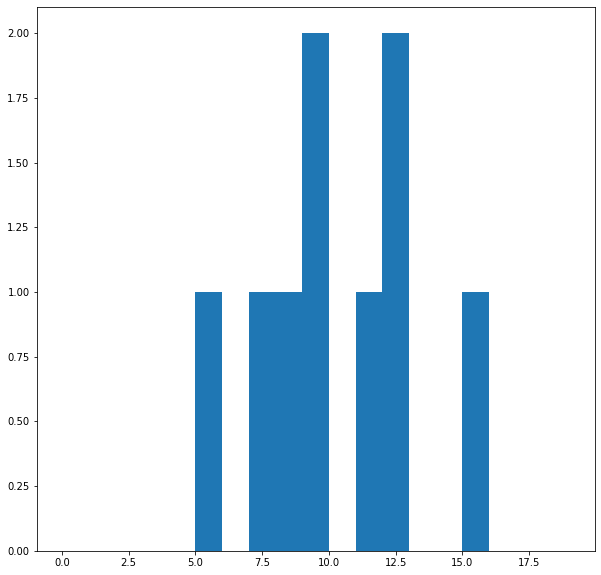

In [3]:
LATI_VALUES = X.loc[:,['lati']].values 
plt.hist(LATI_VALUES, bins=range(20))
print('Ecart type : ' + str(np.std(LATI_VALUES)))
print('Moyenne : ' + str(np.mean(LATI_VALUES)))
print('Variance : ' + str(np.var(LATI_VALUES)))

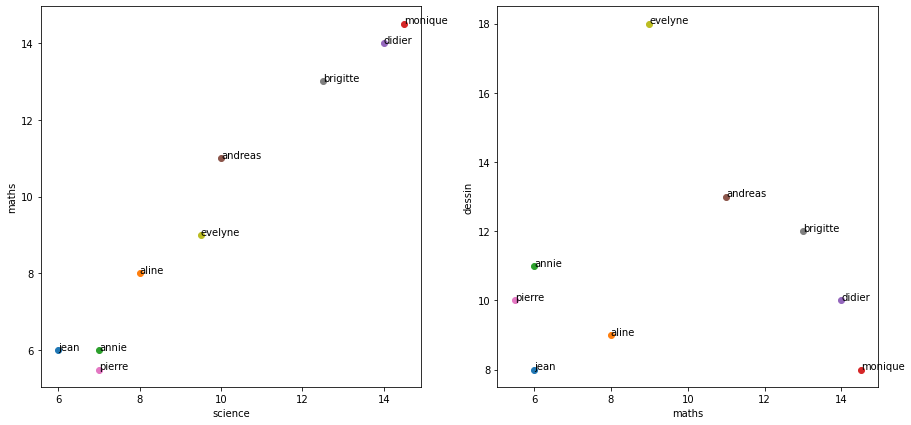

In [4]:
plt.rcParams['figure.figsize'] = (15, 7)

data = X.loc[:, ['scie', 'math']].values
plt.subplot(1, 2, 1)
plt.xlabel('science')
plt.ylabel('maths')
for i in range(len(nomi)):
    plt.scatter(data[i, 0], data[i, 1])
    plt.text(data[i, 0], data[i, 1], nomi[i])
    
data = X.loc[:, ['math', 'd-m ']].values
plt.subplot(1, 2, 2)
plt.xlabel('maths')
plt.ylabel('dessin')
for i in range(len(nomi)):
    plt.scatter(data[i, 0], data[i, 1])
    plt.text(data[i, 0], data[i, 1], nomi[i])
    

## Calcul de l'ACP

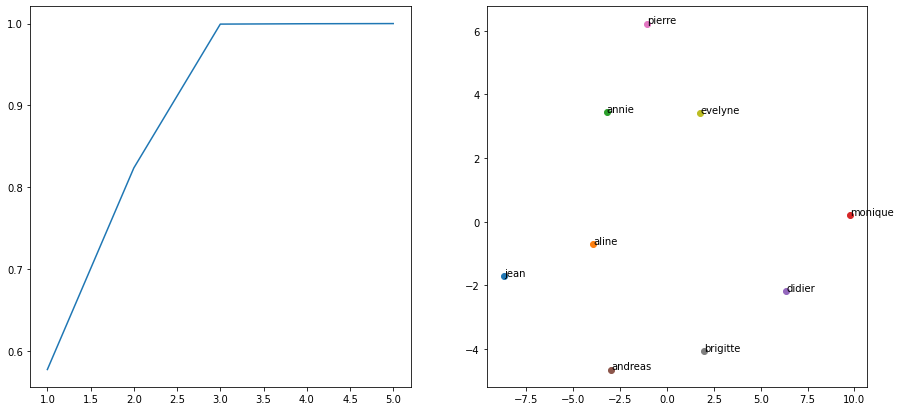

In [5]:
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = (15, 7)

acp = PCA(n_components=len(nomv))
cc = acp.fit_transform(X)


plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(nomv) + 1), np.cumsum(acp.explained_variance_ratio_))

plt.subplot(1, 2, 2)
for i in range(len(nomi)):
    plt.scatter(cc[i, 0], cc[i, 1]) # en changeant les indices, on change les plans factoriels
    plt.text(cc[i, 0], cc[i, 1], nomi[i])


## Représentation

#### Evolution de l'inertie cumulée selon le nombre d'axes

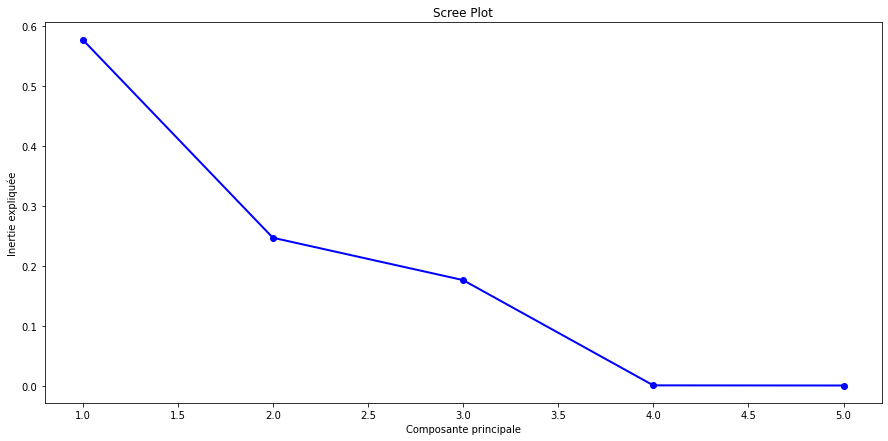

In [6]:
plt.plot(np.arange(acp.n_components_) + 1, acp.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Composante principale')
plt.ylabel('Inertie expliquée')
plt.show()

On choisi de conserver 3 axes.

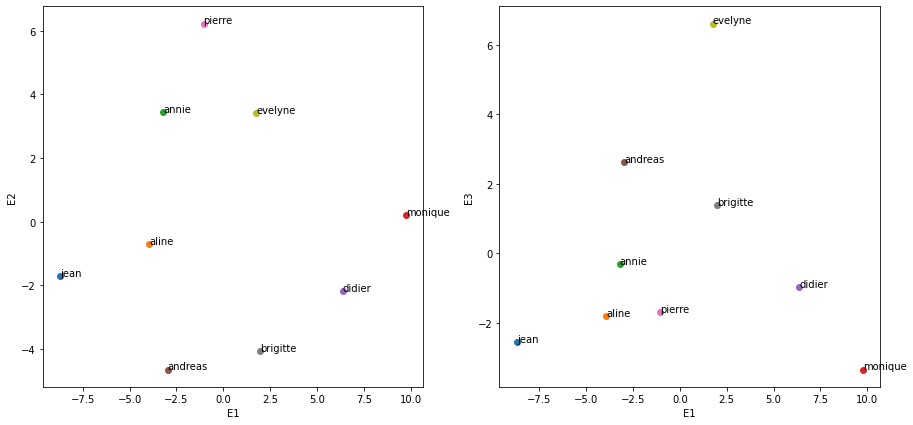

In [7]:

plt.subplot(1, 2, 1)
plt.xlabel("E1")
plt.ylabel("E2")
for i in range(len(nomi)):
    plt.scatter(cc[i, 0], cc[i, 1])
    plt.text(cc[i, 0], cc[i, 1], nomi[i])

plt.subplot(1, 2, 2)
plt.xlabel("E1")
plt.ylabel("E3")
for i in range(len(nomi)):
    plt.scatter(cc[i, 0], cc[i, 2]) 
    plt.text(cc[i, 0], cc[i, 2], nomi[i])


#### Calcul de la corrélation

$$Corr(\Epsilon_k, Y_j)= acp.components[j,k] \times \sqrt{\frac{\lambda_j}{\sigma_k^2}} \\ k=1,...,p \ et \ j=1,...,p$$

In [8]:
import math

# iv : variable initiale
# pca : composantes principales
def compute_corr(iv, pca):
    p = len(pca.components_)
    corr = np.zeros((p, p))
    for k in range(p):
        for j in range(p):
            corr[k, j] = (
                pca.components_[j, k] * 
                math.sqrt(pca.explained_variance_[j] / np.var(iv[:, k], ddof=1))
            )
    
    return corr

In [9]:
corr = compute_corr(X.values, acp)
corr = corr[:, :3]

corr = pd.DataFrame(corr, columns=['E1', 'E2', 'E3'], index=nomv)

print(corr)

            E1        E2        E3
math  0.810417 -0.583770  0.044639
scie  0.901064 -0.432215  0.014185
fran  0.753542  0.650704 -0.091333
lati  0.915707  0.399278 -0.023522
d-m   0.055300  0.133254  0.989536


L'axe E1 est fortement corrélé à toutes les matières, sauf pour le dessin. L'axe E2 est lui plus partagé entre toutes les matières avec des valeurs de corrélation moindre mais plus homogène. Et enfin, l'axe E3 est uniquement fortement corrélé à la matière de dessin. 

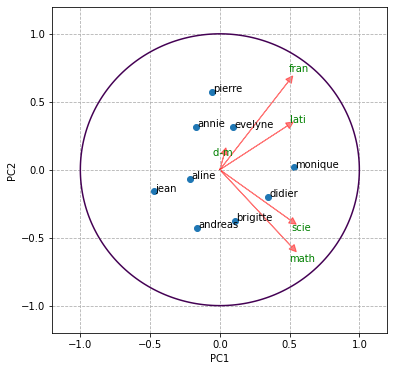

In [10]:
from affichage_acp import my_biplot

my_biplot(
    score = cc[:,0:2],
    coeff = np.transpose(acp.components_[0:2,:]),
    coeff_labels = nomv, 
    score_labels = nomi,
    nomx = "PC1",
    nomy = "PC2"
    )

On remarque que les axes `fran` et `lati` sont proches, comme les axes `scie` et `math`. L'axe `d-m` est plus éloigné des matières scientifiques mais reste peu ressemblant au français et au latin.

# Données réelles

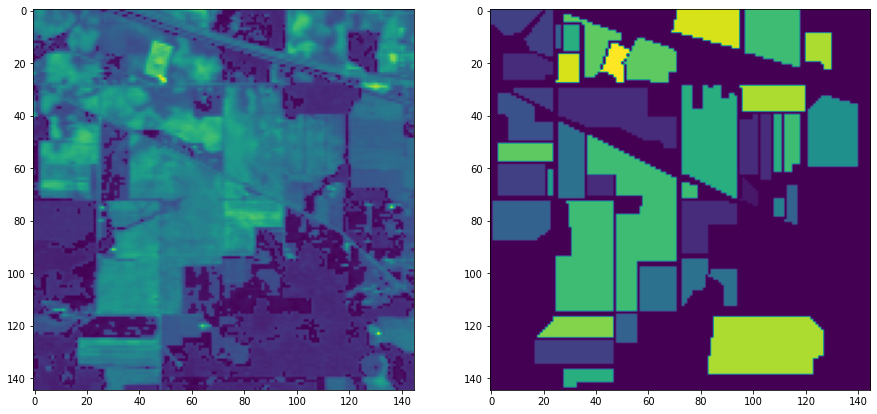

In [11]:
from scipy.io import loadmat

imgtmp = loadmat("Indian_pines_corrected.mat")
img = np.float32(imgtmp['indian_pines_corrected'])

maptmp = loadmat("Indian_pines_gt.mat")
map = maptmp['indian_pines_gt']

res = img[:,:,18]


plt.subplot(1, 2, 1)
plt.imshow((res - np.min(res)) / (np.max(res) - np.min(res)))

plt.subplot(1, 2, 2)
plt.imshow(map)

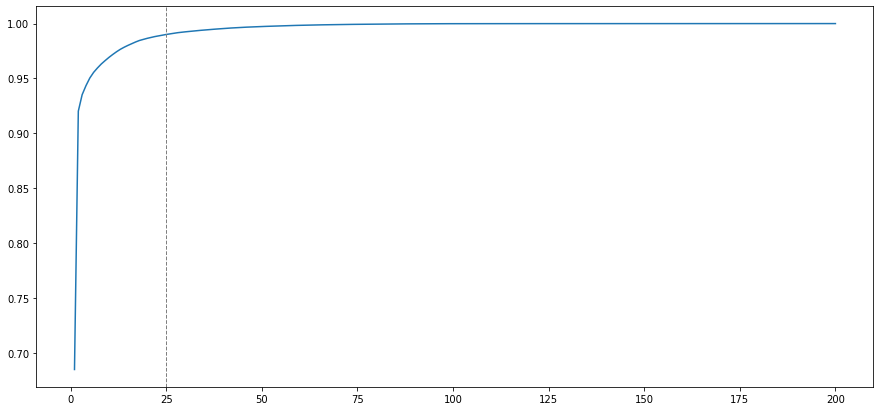

In [12]:
mat = np.reshape(img, ((len(img) * len(img[0])), 200))

acp = PCA(n_components=200)
cc = acp.fit_transform(mat)

plt.plot(np.arange(1, 200 + 1), np.cumsum(acp.explained_variance_ratio_))
plt.axvline(x=25, c='grey', lw=1, linestyle='dashed')


L'inertie tend vers 1 aux environs de 25 axes.

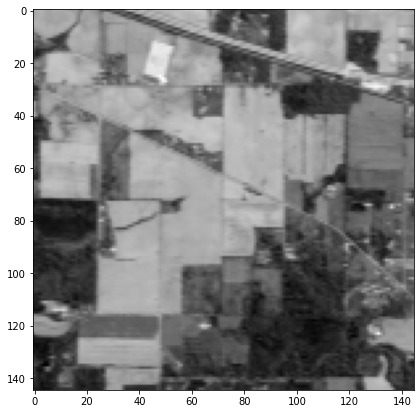

In [13]:
cc2 = cc[:,0]
cc2 = np.reshape(cc2, (145, 145))
plt.imshow(cc2, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


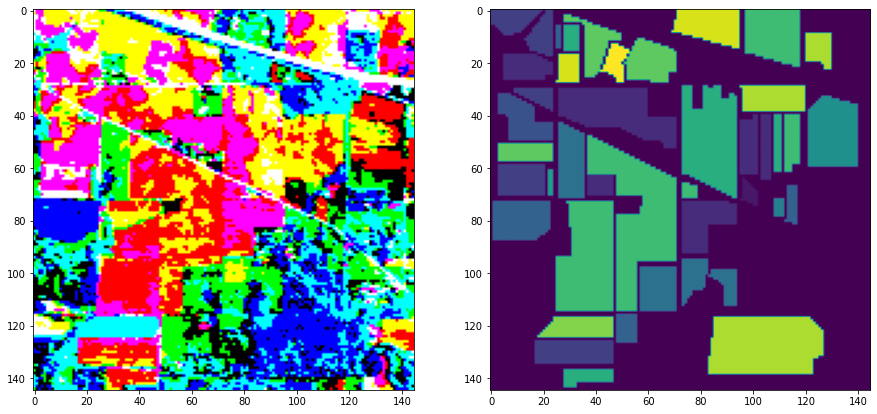

In [14]:
cc_r = cc[:, 0]
cc_g = cc[:, 1]
cc_b = cc[:, 2]

cc_r = np.reshape(cc_r, (145, 145))
cc_g = np.reshape(cc_g, (145, 145))
cc_b = np.reshape(cc_b, (145, 145))

cc_colored = np.stack((cc_r, cc_g, cc_b), axis=2)

plt.subplot(1, 2, 1)
plt.imshow(cc_colored)

plt.subplot(1, 2, 2)
plt.imshow(map)

On identifie bien les routes dans la projection des trois axes (grandes lignes blanches). On distingue aussi les terrains mais ceux-ci sont bruités.

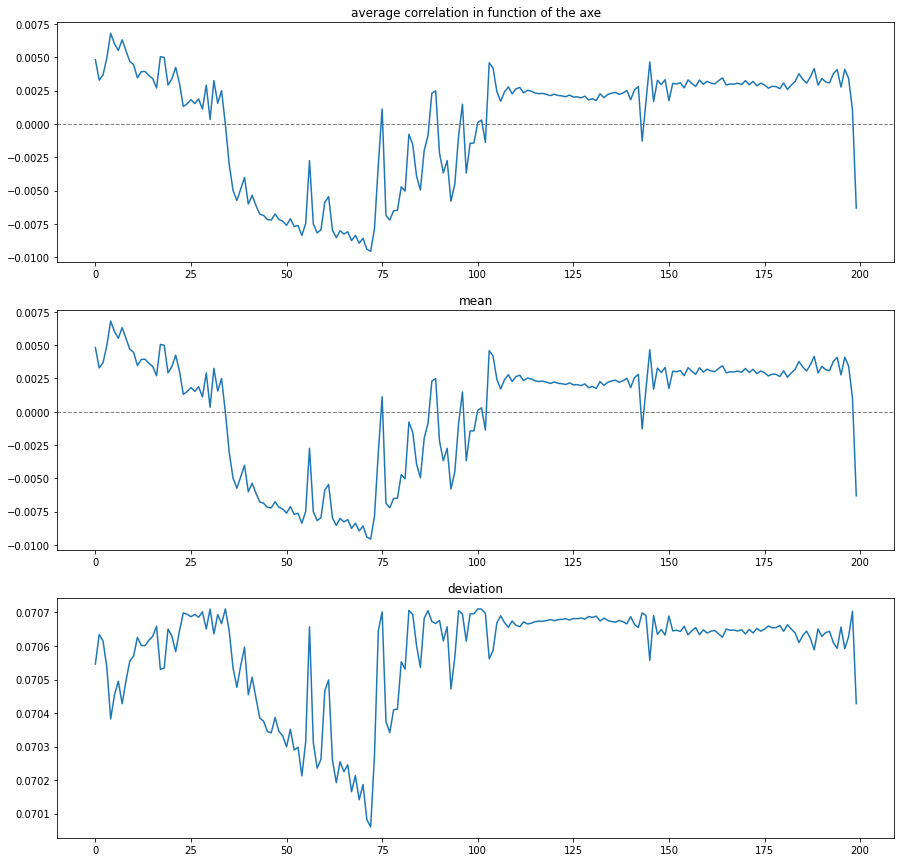

In [15]:
corr = compute_corr(mat, acp)

avg = []
mean = []
std_dev = []


for corr_line in corr:
    avg.append(np.average(corr_line))
    std_dev.append(np.std(corr_line))
    mean.append(np.mean(corr_line))

plt.rcParams['figure.figsize'] = (15, 15)


fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.axhline(y=0, c='grey', lw=1, linestyle='dashed')
ax1.set_title('average correlation in function of the axe')
ax1.plot(avg)

ax2.axhline(y=0, c='grey', lw=1, linestyle='dashed')
ax2.set_title('mean')
ax2.plot(mean)

ax3.set_title('deviation')
ax3.plot(std_dev)

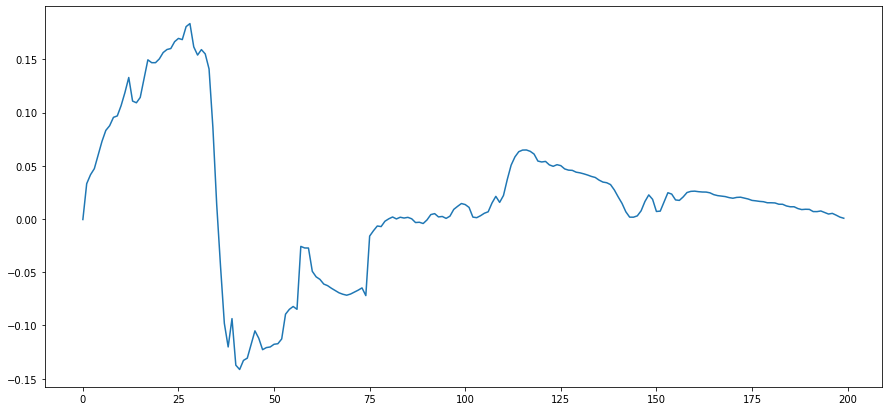

In [16]:
plt.rcParams['figure.figsize'] = (15, 7)

# signature spectrale de l'axe 0
plt.plot(acp.components_[0,:])

# ACP

In [57]:
def my_acp(data):
    n, p = data.shape
    print(n, p)
    c = np.zeros((n, p))
    lamb = np.zeros(p)

    centered_data = data - (np.ones((n, p)) * np.mean(data))
    centered_data = centered_data / centered_data.max()

    # matrice de variance-covariance
    cov = np.cov(centered_data)

    evalues, evectors = np.linalg.eigh(cov)

    c = np.matmul(np.transpose(centered_data), evectors)

    evalues_sum = np.sum(evalues)
    for i in range(p):
        lamb[i] = abs(evalues[i] / evalues_sum)

    return c, lamb, evectors



9 5
[[ 0.03827269  0.41255063  0.44917451 -0.45795303 -0.00282295 -0.05729713
  -0.14673453  0.27381961  1.00882457]
 [ 0.03827269  0.41255063  0.44917451 -0.45795303 -0.00282295 -0.01745375
  -0.08502188  0.05498348  0.8542081 ]
 [ 0.03827269  0.41255063  0.44917451 -0.45795303 -0.00282295 -0.05354
  -0.10143003 -1.0781846   0.07734392]
 [ 0.03827269  0.41255063  0.44917451 -0.45795303 -0.00282295 -0.01658809
  -0.16569927 -0.6817698   0.28843026]
 [ 0.03827269  0.41255063  0.44917451 -0.45795303 -0.00282295 -0.03708318
  -0.12312222  0.4393027  -0.76104439]]


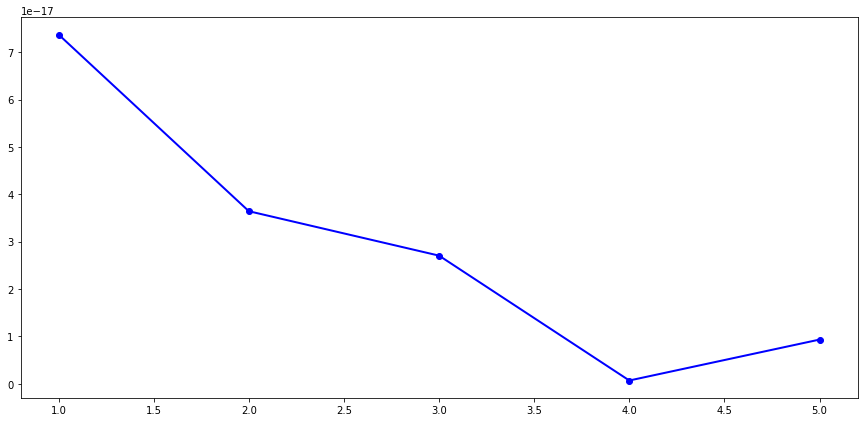

In [58]:
proj, l, u = my_acp(X.values)
print(proj)

plt.plot(np.arange(5) + 1, l, 'o-', linewidth=2, color='blue')
